# Spideymaps Example

## Imports

In [1]:
# builtin Python packages
import os
from os.path import join
from pathlib import Path
import sys

# third party packages
import matplotlib.pyplot as plt
import numpy as np

# local packages
import spideymaps as sm

## Load data
* Example data provided by LAM

### Read localization data from .csv format
* phase masks are in "_PhaseMask.mat" format

In [2]:
labels_sl, locs_csv = sm.read_map_data(
    labels_folders=["..\data\cwx2695_LAM"],
    locs_folders=["..\data\cwx2695_LAM"],
    labels_pattern="_PhaseMask.mat",
    locs_pattern="_AccBGSUB_fits_fits.csv",
    labels_format="smalllabs", # alternative "cellpose"
    locs_format="csv", # alternative "smalllabs"
    pixel_size=1, # for conversion if units are not pixels
    coord_cols=["row", "col"] # if using csv, specify which columns contain coordinates
)
# labels_list : list of 2d integer arrays
# locs_list : list of pandas DataFrames

# conversion from Matlab coordinates to Python
for locs in locs_csv:
    locs.loc[:,'row-1'] = locs.loc[:,'row'] - 1
    locs.loc[:,'col-1'] = locs.loc[:,'col'] - 1

### Read localization data from SMALL-LABS-style .mat files

In [4]:
labels_sl, locs_sl = sm.read_map_data(
    labels_folders=["..\data\cwx2695_LAM"], 
    locs_folders=["..\data\cwx2695_LAM"],
    labels_pattern="_PhaseMask.mat",
    locs_pattern="_AccBGSUB_fits.mat",
    labels_format="smalllabs", # alternative "cellpose"
    locs_format="smalllabs", # alternative "smalllabs"
    pixel_size=1, # for conversion if units are not pixels
    coord_cols=["row", "col"] # if using csv, specify which columns contain coordinates
    )

# conversion from Matlab coordinates to Python
for locs in locs_sl:
    locs.loc[:,'row-1'] = locs.loc[:,'row'] - 1
    locs.loc[:,'col-1'] = locs.loc[:,'col'] - 1

## Define grid

In [5]:
pixel_size = 0.049 # in um

vertebrae_frac_pos = np.arange(1/24, 0.99, 1/24) # how to divide cell along long axis in non-polar region
rings_frac_pos = np.arange(1/6, 0.99, 1/6) # how to divide cell radially
angles = [np.array([np.pi/2]), # what angles to sample in polar region, innermost ring to outermost
        np.array([np.pi/4, np.pi/2]),
        np.array([np.pi/6, np.pi/3, np.pi/2]),
        np.array([np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]),
        np.array([np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]),
        np.array([np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]),]
radius = 0.5 / pixel_size # used to decide where to transition from polar to non-polar, um / (um/px)

grid_params = {
                'vertebrae_frac_pos': vertebrae_frac_pos,
                'rings_frac_pos': rings_frac_pos,
                'angles': angles,
                'radius': radius,
               }

## Calculate for individual cells
* slowest part
* if takes longer than ~5 min, might've hit infinite loop bug

### 

In [6]:
cell_maps_csv, cell_bools = sm.calc_cell_maps(
    labels_sl,
    locs_csv,
    grid_params,
    pixel_size=1,
    coord_cols=('row-1', 'col-1'),
    weights_col='goodfit', # to filter goodfits
    label_col='roinum'
    )

Could not compute adaptive grid for cell # 2


In [7]:
cell_maps_sl, cell_bools = sm.calc_cell_maps(
    labels_sl,
    locs_sl,
    grid_params,
    pixel_size=1,
    coord_cols=('row-1', 'col-1'),
    weights_col='goodfit',
    label_col='roinum'
    )

Could not compute adaptive grid for cell # 2


## Generate representative cell
* Alternatively, can load saved representation cell

In [8]:
model_cell_bool = sm.calc_model_cell(cell_bools)
model_cell = sm.get_cell_grid(model_cell_bool, 
                           grid_params['vertebrae_frac_pos'],
                           grid_params['rings_frac_pos'],
                           grid_params['angles'], 
                           grid_params['radius'],
                           sigma_spine=1.5,
                           sigma_skin=2)

sym_elements = sm.symmetric_grid_elements(model_cell["polygons"])

## Sum cells, symmetrify, and normalize
* Current default behavior is to normalize by dividing by the mean density

In [9]:
# normalize localization data from SMALL-LABS
counts_total_sl = sm.sum_cell_maps(cell_maps_sl, val_key='counts')
areas_total_sl  = sm.sum_cell_maps(cell_maps_sl, val_key='areas')
counts_per_area_sl = sm.divide_dicts(counts_total_sl, areas_total_sl)
cpa_normed_sl = sm.normalize_map(counts_per_area_sl, weights=areas_total_sl)
cpa_norm_sym_sl = sm.average_sym_elements(cpa_normed_sl, sym_elements)

# normalize localization data from .csv
counts_total_csv = sm.sum_cell_maps(cell_maps_csv, val_key='counts')
areas_total_csv  = sm.sum_cell_maps(cell_maps_csv, val_key='areas')
counts_per_area_csv = sm.divide_dicts(counts_total_csv, areas_total_csv)
cpa_normed_csv = sm.normalize_map(counts_per_area_csv, weights=areas_total_csv)
cpa_norm_sym_csv = sm.average_sym_elements(cpa_normed_csv, sym_elements)

## Render

### Render data from .csv

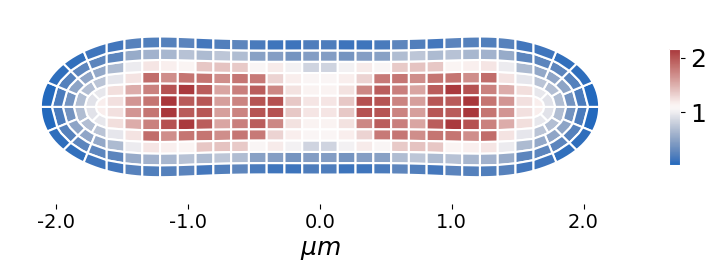

In [10]:
vabs = np.abs(np.array(list(cpa_normed_csv.values()))-1).max()
# render_map(model_cell["polygons"], cpa_norm_sym, vmin=1-vabs, vmax=1+vabs)
# render_map(model_cell["polygons"], cpa_norm_sym, vmin=1.5, vmax=1.9)
sm.render_map(model_cell["polygons"], cpa_norm_sym_csv)

### Render data from SMALL-LABS format

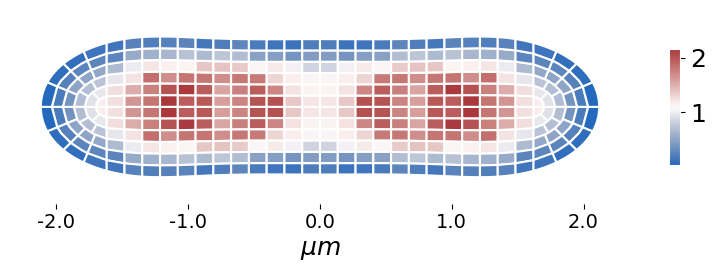

In [11]:
vabs = np.abs(np.array(list(cpa_normed_sl.values()))-1).max()
# render_map(model_cell["polygons"], cpa_norm_sym, vmin=1-vabs, vmax=1+vabs)
# render_map(model_cell["polygons"], cpa_norm_sym, vmin=1.5, vmax=1.9)
sm.render_map(model_cell["polygons"], cpa_norm_sym_sl)

## Plot normalized intensity along the equator

''

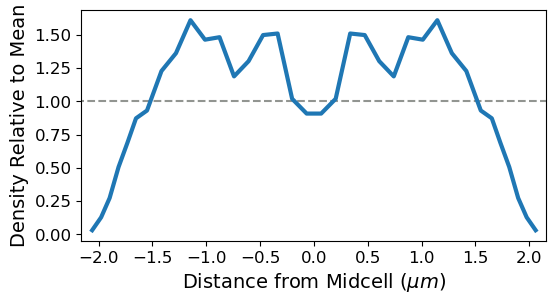

In [12]:
vals, pos = sm.get_long_axis_vals(cpa_norm_sym_sl, model_cell["polygons"])
pos_centered = pos - np.median(pos)

plt.figure(figsize=(6,3))
plt.plot([-3, 3], [1, 1], '--', color='xkcd:gray')

plt.plot(pos_centered*pixel_size, vals/vals.mean(), '-', lw=3)

# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=12, frameon=False)
plt.xlim([pos_centered[0]*pixel_size - 0.1,
          pos_centered[-1]*pixel_size + 0.1])

plt.xlabel(r'Distance from Midcell ($\mu m$)', fontsize=14)
plt.ylabel('Density Relative to Mean', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
;